In [1]:
import torch
import torch.nn.functional as F 
import matplotlib.pyplot as plt 
%matplotlib inline 


In [2]:
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2023-05-10 06:07:17--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.006s  

2023-05-10 06:07:17 (38.9 MB/s) - ‘names.txt’ saved [228145/228145]



In [3]:
words = open('names.txt','r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
##build the Vocabulary of characers and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [8]:
##build the dataset
block_size = 3 #content_length

def build_dataset(words):
  X,Y = [],[]
  for w in words:
    context= [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape,Y.shape)
  return X,Y

In [9]:
import random 
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,Ytr = build_dataset(words[:n1])
Xdev,Ydev = build_dataset(words[n1:n2])
Xte,Yte = build_dataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [11]:
example =  torch.randn(27)
torch.show((3.9),example)

AttributeError: ignored

In [12]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,10),generator=g)
W1 = torch.randn((30,200),generator=g)
b1 = torch.randn(200,generator=g)
W2 = torch.randn((200,27),generator=g)
b2 = torch.randn(27,generator=g)
parameters = [C,W1,b1,W2,b2]



In [13]:
sum(p.nelement() for p in parameters )

11897

In [14]:
for p in parameters:
  p.requires_grad =True

In [15]:
lre =  torch.linspace(-3,0,1000)
lrs = 10**lre


In [17]:
lri = []
lossi = []
stepi = []

for i in range(20000):
  ##minibatch construct
  ix = torch.randint(0,Xtr.shape[0],(32,))

  #forward pass
  emb = C[Xtr[ix]] # (32,3,2)
  h = torch.tanh(emb.view(-1,30) @ W1 + b1 )
  logits = h @ W2 + b2 
  loss = F.cross_entropy(logits,Ytr[ix])

  ##backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  ##update
  ##lr  = lr[i]

  lr = 0.1 if i < 10000 else 0.01
  for p in parameters:
    p.data+= -lr* p.grad 

  ## track stts
  stepi.append(i)
  lossi.append(loss.log10().item())



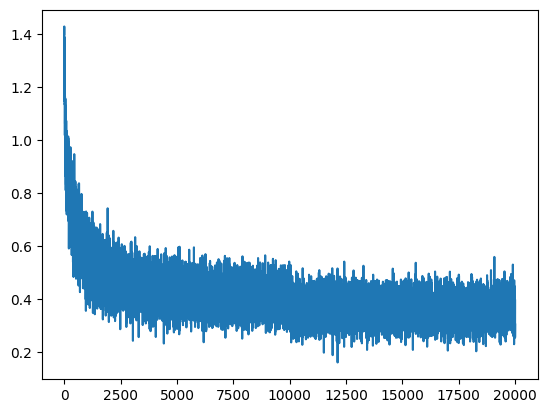

In [18]:
plt.plot(stepi,lossi)

In [19]:
##training the loss 
emb = C[Xtr] # ( 32,3,2)
h = torch.tanh(emb.view(-1,30) @ W1 + b1  )
logits =  h @ W2 + b2 
loss = F.cross_entropy(logits,Ytr)
loss

tensor(2.3193, grad_fn=<NllLossBackward0>)

In [21]:
## validation loss
emb = C[Xdev]
h = torch.tanh(emb.view(-1,30) @ W1 + b1  )
logits = h @ W2 + b2 
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.3328, grad_fn=<NllLossBackward0>)

In [24]:
## Test loss
C[0].shape

torch.Size([10])

In [28]:
len(Xdev)

22655

In [29]:
C[[0,0,0]]

tensor([[ 1.5957,  0.7901,  0.2522, -0.6234,  0.2834, -0.0333, -1.8089,  0.7315,
          0.5680,  1.2334],
        [ 1.5957,  0.7901,  0.2522, -0.6234,  0.2834, -0.0333, -1.8089,  0.7315,
          0.5680,  1.2334],
        [ 1.5957,  0.7901,  0.2522, -0.6234,  0.2834, -0.0333, -1.8089,  0.7315,
          0.5680,  1.2334]], grad_fn=<IndexBackward0>)

In [30]:
## test loss
emb  = C[Xte]
h = torch.tanh(emb.view(-1,30) @ W1 + b1  )
logits = h @ W2 + b2 
loss = F.cross_entropy(logits,Yte)
loss

tensor(2.3346, grad_fn=<NllLossBackward0>)

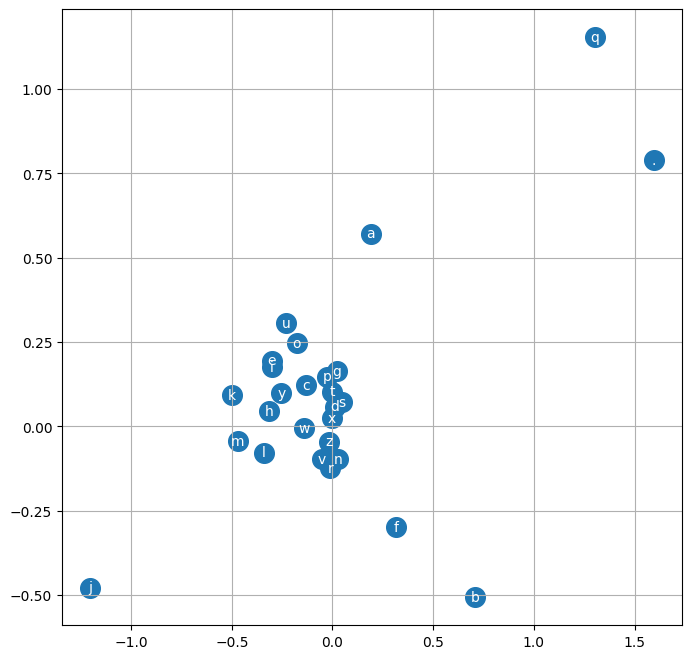

In [33]:
## visualite 
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data,C[:,1].data,s=200)
for i in range(C.shape[0]):
  plt.text(C[i,0].item(),C[i,1].item(),itos[i],ha='center',va='center',color='white')
plt.grid('minor')

In [34]:
## sample from the model
g = torch.Generator().manual_seed(2147483647+10)

for _ in range(20):
  out = []
  context = [0]*block_size
  while True:
    emb = C[torch.tensor([context])]
    h = torch.tanh(emb.view(1,-1) @ W1 + b1 )
    logits = h @ W2 + b2
    probs = F.softmax(logits,dim=1)
    ix = torch.multinomial(probs,num_samples=1,generator=g).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix ==0:
      break
  print(''.join(itos[i] for i in out ))

mri.
ammyazheees.
nahlyah.
rethan.
brerlee.
adered.
elii.
say.
jeane.
elieananareelle.
malka.
cajshdenrishianel.
kin.
ren.
jernethana.
uberted.
raylenn.
eha.
kay.
mis.
